In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun()
tools = [tool]

In [3]:
tool.invoke("Trump gold coin 2025")

"For those seeking to acquire 2025 Trump-themed gold and silver coins, the U.S. Gold Bureau offers a trusted and reputable option. Available coins include: 2025 1oz Gold American Eagle MS70 Coin - Donald Trump. 2025 1oz Silver American Eagle MS70 Coin - Donald Trump. Each coin is authenticated and certified, offered exclusively by the U.S ... As of April 2025, 1 oz silver Trump coins contain approximately $30 worth of silver at current market prices. ... A 1-ounce gold Trump coin from a reputable private mint might be more valuable to ... On the obverse of the 2025 1/10 oz Gold Eagle Coin, collectors will find the iconic Lady Liberty design first introduced on the $20 Gold Double Eagle in 1907. Created by Augustus Saint-Gaudens, this masterpiece depicts Liberty stepping forward with a torch in one hand and an olive branch in the other, with the U.S. Capitol and radiant sun rays ... Trump Coins is proud to produce the only and official gold designed by President Donald J. Trump. This is

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "azure_openai:gpt-4o",
    azure_deployment="gpt-4o",
)

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [6]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_name = tool_call['name']
            tool_args = tool_call['args']
            tool_call_id=tool_call["id"]
            tool_result = self.tools_by_name[tool_name].invoke(
                tool_args
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_name,
                    tool_call_id=tool_call_id,
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [7]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

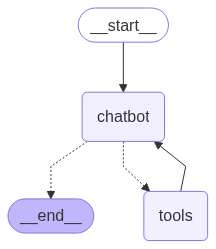

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [10]:
user_input = "Tell me about the gold coin website launched by Trump in 2025"
stream_graph_updates(user_input)

Assistant: 
Calling tool: duckduckgo_search with args: {'query': 'Trump gold coin website 2025'}
Assistant: "For those seeking to acquire 2025 Trump-themed gold and silver coins, the U.S. Gold Bureau offers a trusted and reputable option. Available coins include: 2025 1oz Gold American Eagle MS70 Coin - Donald Trump. 2025 1oz Silver American Eagle MS70 Coin - Donald Trump. Each coin is authenticated and certified, offered exclusively by the U.S ... Each 2025 1/2 oz American Gold Eagle Coin arrives in protective plastic slabs featuring a unique label. Each label includes a portrait of President Donald J. Trump alongside the JM Bullion logo. These coins have been graded Mint State 70, ensuring flawless condition with the full, original mint luster. Trump Coins is proud to produce the only and official gold designed by President Donald J. Trump. This is a 1oz .9999 / 24KT gold medallion and struck with a proof finish featuring our 45th President's profile on the obverse and 47 on the reve

#### Analyzing the steps

In [12]:
user_input = "Tell me about the gold coin website launched by Trump in 2025"

for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
    # Handle chatbot node (tool calls and messages)
    if "chatbot" in event:
        for message in event["chatbot"]["messages"]:
            # Check for tool calls
            if hasattr(message, "tool_calls") and message.tool_calls:
                print("Tool usage:")
                for tool_call in message.tool_calls:
                    tool_name = tool_call["name"]
                    tool_args = tool_call["args"]
                    tool_id = tool_call["id"]
                    print(f"{tool_id} | {tool_name} | {tool_args}")
            # Print chatbot message content if no tool calls
            elif message.content:
                print("Message output:")
                print(message.content)

    # Handle tools node (tool execution results)
    if "tools" in event:
        for message in event["tools"]["messages"]:
            print("Tool output:")
            tool_call_id = message.tool_call_id
            message_id = message.id
            tool_name = message.name
            content_preview = message.content[:100]  # Limit content to 100 characters
            print(f"{tool_call_id} | {message_id} | {tool_name} | {content_preview}")


Tool usage:
call_3hVJpL5ZXb8lzJHUbvV6qOah | duckduckgo_search | {'query': 'Trump gold coin website launched 2025'}
Tool output:
call_3hVJpL5ZXb8lzJHUbvV6qOah | b6e415e0-7ae2-493e-81e1-49e6561f0b29 | duckduckgo_search | "The \"gold card\" website allowing people to buy U.S. permanent residency for $5 million will launc
Message output:
It seems there is significant public and media interest in a concept related to a "gold coin" or "gold card" initiative associated with former President Donald Trump in 2025. However, the results more prominently feature a "Gold Card" initiative linked to U.S. permanent residency or a pathway to citizenship for a $5 million fee. Below is a summary:

1. **Trump Gold Card**: This initiative allows foreigners to pay a one-time $5 million fee to acquire permanent residency or potentially citizenship in the U.S. The funds are suggested to help with national debt reduction.

2. **Website Launch**: The Trump administration reportedly launched a website for this i